# Introduction to working with NIX

For an online introduction please see the [nixio readthedocs page](https://nixio.readthedocs.io). This introduction closely follows the introduction presented there.

This notebook is setup to be used with Python 3(.6+). Also to properly run this notebook the following libraries need to be installed:
- `pip install numpy`
- `pip install matplotlib`
- `pip install nixio==1.5.0b3`

Note: nixio 1.5.0b3 is a beta release with many new exciting features of NIX. As of the time of the presentation (24.07.2019) these features have not made it into the main NIX release. So if you are using this notebook at a later point in time, installing via `pip install nixio` should be enough.

## Storing data

When storing data, we have two main requirements:

1. We want to be able to store n-dimensional data structures.
2. The data structures must be self-explanatory, that is, they must contain sufficient information to draw a basic plot of the data.

![](https://nixio.readthedocs.io/en/latest/_images/regular_sampled.png)

Considering the simple plot above, we can list all information that it shows and by extension, that needs to be stored in order to reproduce it.

- the data (voltage measurements)
- the y-axis labeling, i.e. label (voltage) and unit (mV)
- the x-axis labeling, i.e. label (time) and unit (s)
- the x-position for each data point
- a title/legend

In this, and in most cases, it would be inefficient to store x-, and y-position for each data point. The voltage measurements have been done in regular (time) intervals. Thus, we rather need to store the measured values and a definition of the x-axis consisting of an offset, the sampling interval, a label, and a unit.

This is exactly the approach chosen in NIX. For each dimension of the data a dimension descriptor must be given. In NIX we define three (and a half) dimension descriptors:

1. SampledDimension: Used if a dimension is sampled at regular intervals.
- RangeDimension: Used if a dimension is sampled at irregular intervals.
- There is a special case of the RangeDimension, the AliasRangeDimension, which is used when e.g. event times are stored.
- SetDimension: Used for dimensions that represent categories rather than physical quantities.


## Some data to store

Before we can store any data we need to have it lying around somewhere. Lets re-create the example data for the figure we saw above and then see, how we can store this data in a NIX file.

In [230]:
# Lets create some example data:
import numpy as np

freq = 5.0;
samples = 1000
sample_interval = 0.001
time = np.arange(samples)
voltage = np.sin(2 * np.pi * time * freq/samples)


<IPython.core.display.Javascript object>


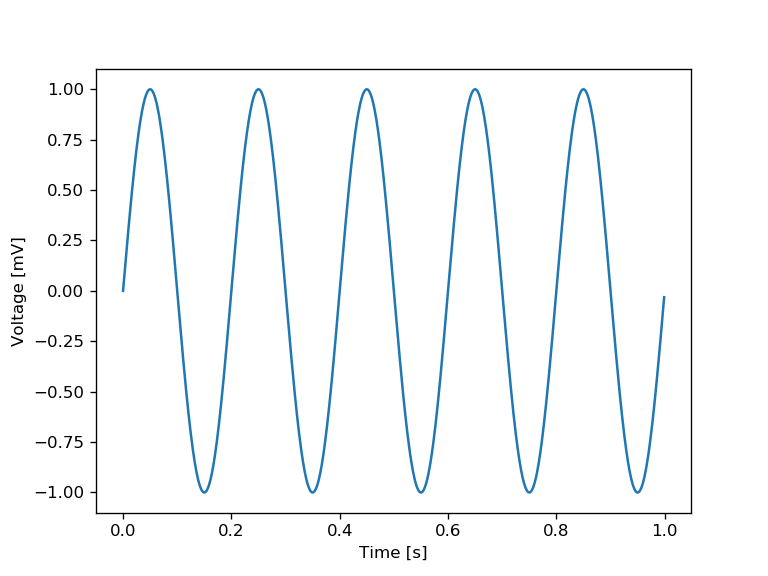

In [231]:
# Lets quickly check how the data we will store actually looks like
# The next line is jupyter notebook specific and will allow us to see plots. It only works in python3.
%matplotlib notebook

import matplotlib.pyplot as plot

plot.plot(time*sample_interval, voltage)
plot.xlabel('Time [s]')
plot.ylabel('Voltage [mV]')

plot.show()


This is perfect data, we would like to keep it and store it in a file. So lets persist this wonderful data in a NIX file.

## The DataArray

The DataArray is the most central entity of the NIX data model. As almost all other NIX-entities it requires a name and a type. Both are not restricted but names must be unique inside a Block. type information can be used to introduce semantic meaning and domain-specificity. Upon creation, a unique ID will be assigned to the DataArray.

The DataArray stores the actual data together with label and unit. In addition, the DataArray needs a dimension descriptor for each dimension. The following snippet shows how to create a DataArray and store data in it.

In [234]:
import nixio

# First create a file we'll use to work with

# Files can be opened in FileMode "ReadOnly", "ReadWrite" and "Overwrite"
# ReadOnly ... Opens an existing file for reading
# ReadWrite ... Opens an existing file for editing or creates a new file
# Overwrite ... Truncates and opens an existing file or creates a new file
f = nixio.File.open('Tutorial.nix', nixio.FileMode.Overwrite)

# Please note, that nix works on an open file and reads and writes directly from and to this file.
# Always close the file using 'f.close()' when you are done.


As you can see in the [NIX data model](https://github.com/G-Node/nix/wiki/Model-Definition), NIX files are hierarchically structured. Data is stored in 'DataArrays'. DataArrays are contained in 'Blocks'. When we want to create a DataArray, we need to create at least one Block first, that will contain the DataArray.

In [235]:
# Lets check the blocks we currently have defined in our file; it should be emtpy
f.blocks


[]

In [236]:
# Lets see how we can create a block in our file; we'll use the handy python help function to get more information
help(f.create_block)


Help on method create_block in module nixio.file:

create_block(name, type_, compression=<Compression.Auto: 'Auto'>) method of nixio.file.File instance
    Create a new block inside the file.
    
    :param name: The name of the block to create.
    :type name: str
    :param type_: The type of the block.
    :type type_: str
    :param compression: No, DeflateNormal, Auto (default: Auto)
    
    :returns: The newly created block.
    :rtype: Block



In [237]:
# "name" and "type" of a block can be used to filter and find our blocks later on when the file contains more content
block = f.create_block(name="basic_examples", type_="examples")

# Please note at this point, that the 'name' of any NIX entity e.g. Blocks, DataArrays, etc. has to be unique
# since it can be used to find and return this exact entity via the 'name'.
# The 'type' can also be used to find entities, but it does not need to be unique. You can use 'name' to uniquely
# identify a particular entity and use 'type' to find groups of related entities

In [238]:
# Great, we have an empty block
block

Block: {name = basic_examples, type = examples, id = 0e3c181d-e9b5-4910-87d3-27b240dac60c}

In [239]:
# And this block resides within our file
f.blocks

[Block: {name = basic_examples, type = examples, id = 0e3c181d-e9b5-4910-87d3-27b240dac60c}]

Now we are finally set up to put our data in our file!

In [240]:
# First lets check how we can actually create a DataArray
help(block.create_data_array)

Help on method create_data_array in module nixio.block:

create_data_array(name, array_type, dtype=None, shape=None, data=None, compression=<Compression.Auto: 'Auto'>) method of nixio.block.Block instance
    Create a new data array for this block. Either ``shape``
    or ``data`` must be given. If both are given their shape must agree.
    If ``dtype`` is not specified it will default to 64-bit floating
    points.
    
    :param name: The name of the data array to create.
    :type name: str
    :param array_type: The type of the data array.
    :type array_type: str
    :param dtype: Which data-type to use for storage
    :type dtype:  :class:`numpy.dtype`
    :param shape: Layout (dimensionality and extent)
    :type shape: tuple of int or long
    :param data: Data to write after storage has been created
    :type data: array-like data
    :param compression: En-/disable dataset compression.
    :type compression: :class:`~nixio.Compression`
    
    :returns: The newly created d

In [241]:
# Now we create the DataArray within the Block created above and with the data
# We also add the appropriate labels immediately.

da = block.create_data_array(name="data_regular", array_type="sine", data=voltage)
da.label = "voltage"
da.unit = "mV"

In [242]:
# Now we will also add the appropriate Dimension to this DataArray, so it can be correctly interpreted for
# later plotting. We will look into the different Dimensions in a second.

# First we check how to properly create the Dimension we need
help(da.append_sampled_dimension)

Help on method append_sampled_dimension in module nixio.data_array:

append_sampled_dimension(sampling_interval, label=None, unit=None, offset=None) method of nixio.data_array.DataArray instance
    Append a new SampledDimension to the list of existing dimension
    descriptors.
    
    :param sampling_interval: The sampling interval of the SetDimension
                              to create.
    :type sampling_interval: float
    
    :returns: The newly created SampledDimension.
    :rtype: SampledDimension



In [243]:
# And lets add it to our DataArray, again with 
dim = da.append_sampled_dimension(sample_interval)
dim.label = "time"
dim.unit = "s"

In the example shown above, the NIX library will figure out the dimensionality of the data, the shape of the data and its type. The data type and the dimensionality (i.e. the number of dimensions) are fixed once the DataArray has been created. The actual size of the DataArray can be changed during the life-time of the entity.

In case you need more control, DataArrays can be created empty for later filling e.g. during data acquisition.

In [244]:
# Now lets see if we can access our data and do something useful with it e.g. plot it:
plot_data = f.blocks['basic_examples'].data_arrays['data_regular']
plot_data

DataArray: {name = data_regular, type = sine, id = 5b38fde6-b8b6-4e92-8d6c-3b21c7ff83de}

In [245]:
plot_data[:5]

array([ 0.        ,  0.03141076,  0.06279052,  0.09410831,  0.12533323])

In [246]:
# Lets check the dimensionality of our data
plot_data.dimensions

[SampledDimension: {index = 1}]

In [247]:
# Since we only stored the sampling rate with the second dimension we save quite a bit of space

dim = plot_data.dimensions[0]
dim.sampling_interval

0.001

In [248]:
# Compared to the original time array:
time

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

<IPython.core.display.Javascript object>


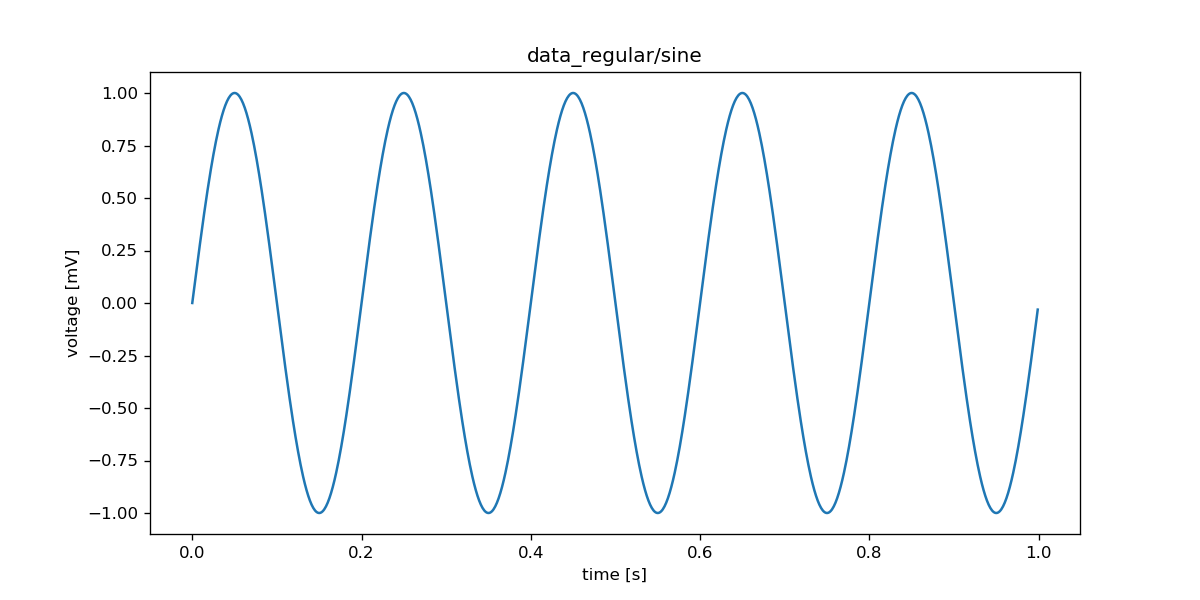

Text(0.5,1,'data_regular/sine')

In [250]:
# Lets plot all data from file using all information provided by the file

y = plot_data[:]
# The sampled dimension axis function applies its interval to a passed array to recreate the original time array
x = plot_data.dimensions[0].axis(y.shape[0])

plot.figure(figsize=(10,5))
plot.plot(x, y, '-')
plot.xlabel("%s [%s]" % (dim.label, dim.unit))
plot.ylabel("%s [%s]" % (plot_data.label, plot_data.unit))
plot.title("%s/%s" % (plot_data.name, plot_data.type))

View, that was already nice. As you have seen in the example we dealt with regularly sampled data. What do we do if we have data that is not regularly sampled? As mentioned at the beginning, NIX supports
- regularly sampled data
- irregularly sampled data
- set (event) data
- one dimensional data

In [251]:
# Lets create some irregularly sampled data and store it

duration = 1.0
interval = 0.02
time_points = np.around(np.cumsum(np.random.poisson(interval*1000, int(1.5*duration/interval)))/1000., 3)
time_points = time_points[time_points <= duration]

data_points = np.sin(5 * np.arange(0, time_points[-1] * 2 * np.pi, 0.001))
data_points = data_points[np.asarray(time_points / 0.001 * 2 * np.pi, dtype=int)]


In [252]:
# Check the block we want to save this data in:
block

Block: {name = basic_examples, type = examples, id = 0e3c181d-e9b5-4910-87d3-27b240dac60c}

In [253]:
data_irr = block.create_data_array(name="data_irregular", array_type="sine", data=data_points)
data_irr.label = "Voltage"
data_irr.unit = "mV"

In [254]:
dim = data_irr.append_range_dimension(time_points)
dim.label = "time"
dim.unit = "s"

<IPython.core.display.Javascript object>


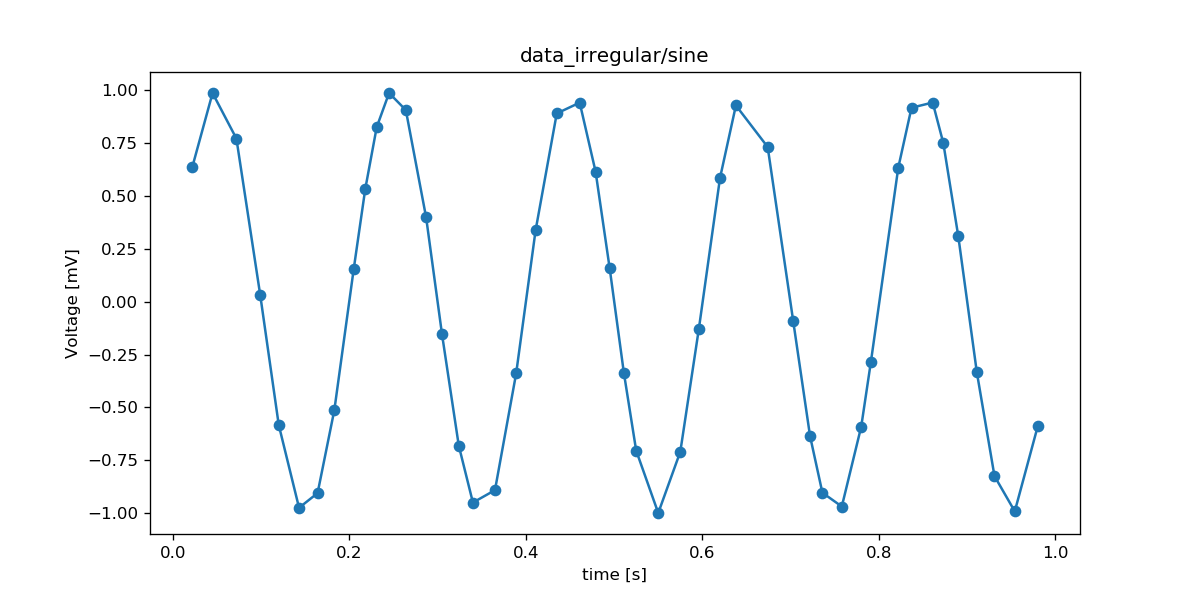

Text(0.5,1,'data_irregular/sine')

In [255]:
# Lets plot our data again
plot_data = f.blocks['basic_examples'].data_arrays['data_irregular']

x_dim = plot_data.dimensions[0]
x = list(x_dim.ticks)

y = plot_data[:]

plot.figure(figsize=(10,5))
plot.plot(x, y, '-o')
plot.xlabel("%s [%s]" % (x_dim.label, x_dim.unit))
plot.ylabel("%s [%s]" % (plot_data.label, plot_data.unit))
plot.title("%s/%s" % (plot_data.name, plot_data.type))

In [257]:
# Next we will store some basic set or "event" data

data_points = [281, 293, 271, 300, 285, 150]

data_event = block.create_data_array(name="data_event", array_type="event", data=data_points)
data_event.label = "temperature"
data_event.unit = "K"

dim = data_event.append_set_dimension()
dim.labels = ["Response A", "Response B", "Response C", "Response D", "Response E", "Response F"]

<IPython.core.display.Javascript object>


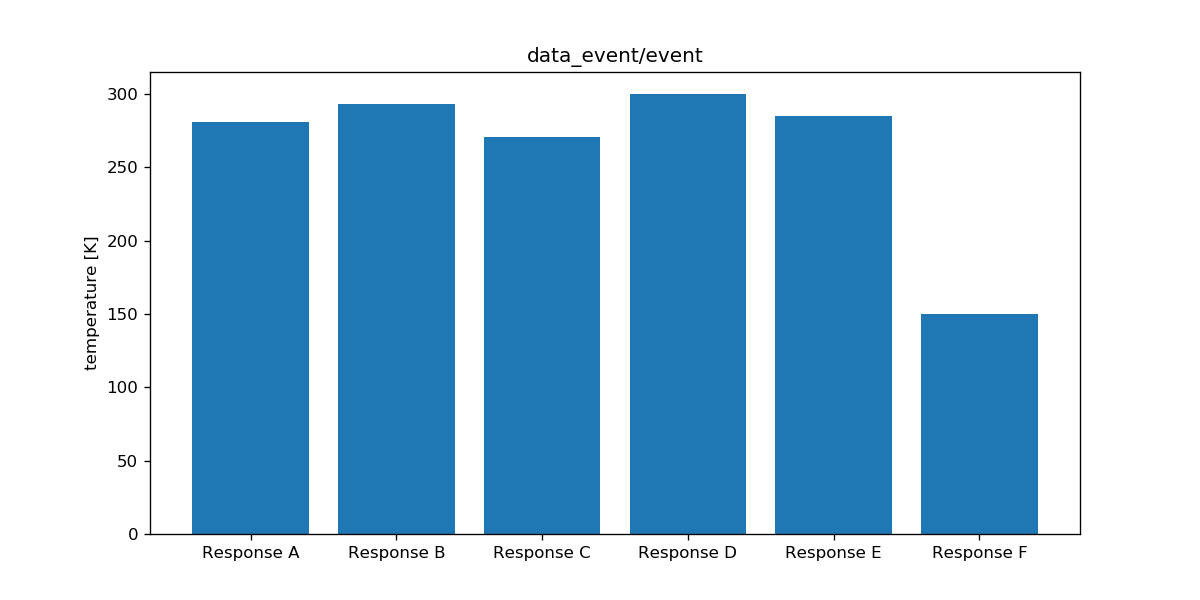

Text(0.5,1,'data_event/event')

In [258]:
# And lets see how we can plot this
plot_data = f.blocks['basic_examples'].data_arrays['data_event']

x_dim = plot_data.dimensions[0]
y = plot_data[:]
index = np.arange(len(y))

plot.figure(figsize=(10,5))
plot.bar(index, y)
plot.xticks(index, x_dim.labels)
plot.ylabel("%s [%s]" % (plot_data.label, plot_data.unit))
plot.title("%s/%s" % (plot_data.name, plot_data.type))


# Multiple related signals in one DataArray - Multidimensional data

Now we know how to save two dimensional data in a DataArray. Due to the ability of adding dimensions NIX also supports multidimensional data and is able to properly describe it. As examples one could save 2D images including their different color channels into one DataArray.

Another use case would be to store different time series data together in one DataArray.

In [263]:
# Lets create data for two related time series and store them together
# ---- MOCK DATA; the code can be safely ignored --------
freq = 5.0;
samples = 1000
sample_interval = 0.001
time = np.arange(samples)
voltage_trace_A = np.sin(2 * np.pi * time * freq/samples)
voltage_trace_B = np.cos(2 * np.pi * time * freq/samples)

# We use a numpy function that will stack both signal
voltage_stacked = np.vstack((voltage_trace_A, voltage_trace_B))
# ---- MOCK DATA end --------

# Lets create a new DataArray with our multi-dimensional data
data_related = block.create_data_array(name="data_multi_dimension", array_type="multi", data=voltage_stacked)
data_related.label = "voltage"
data_related.unit = "mV"


In [264]:
# To properly describe the DataArray we need to add two dimensions
# First we describe the depth of the stacked arrays
dim_set = data_related.append_set_dimension()
# Take care to add the lables in the order the arrays were stacked above.
dim_set.labels = ["Trace_A", "Trace_B"]


In [265]:
# Second we add the second dimension that is common to both stacked arrays of data and describes time
dim_sample = data_related.append_sampled_dimension(sample_interval)
dim_sample.label = "time"
dim_sample.unit = "s"


In [266]:
# Lets harvest the fruits of our labour
plot_data = f.blocks['basic_examples'].data_arrays['data_multi_dimension']


<IPython.core.display.Javascript object>


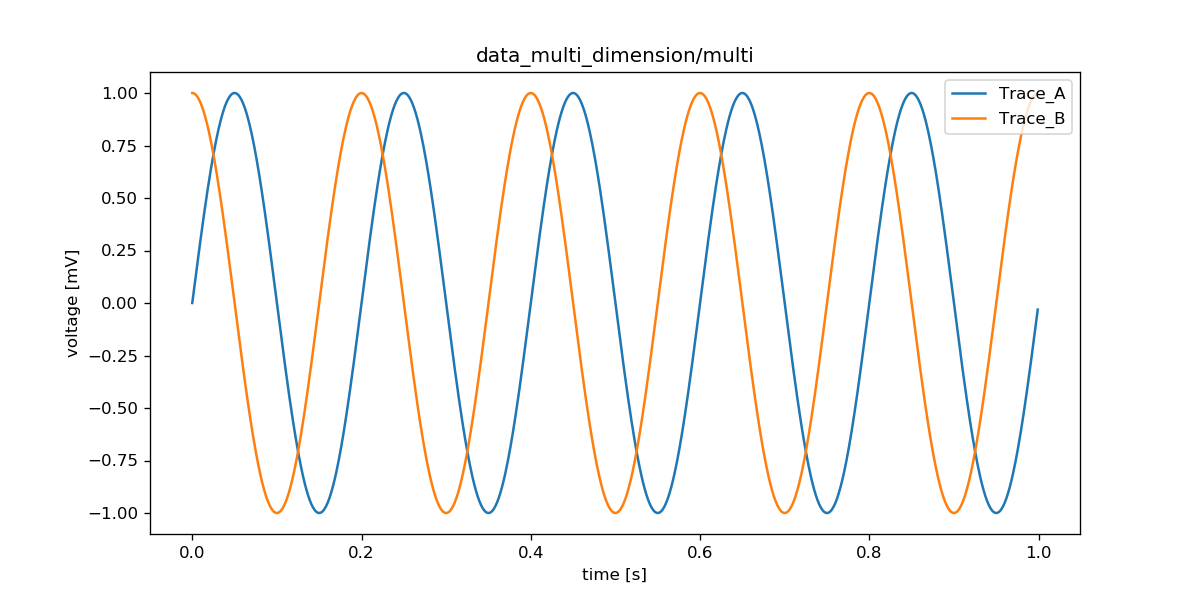

In [281]:
dim_set = plot_data.dimensions[0]
dim_sampled = plot_data.dimensions[1]

# We need to know the dimension of the x-axis, so we compute the 
# timepoints from one of the stored arrays and the sampled dimension interval
data_points_A = plot_data[0, :] # Here we access the first of the multidimensional arrays

time_points = dim_sampled.axis(data_points_A.shape[0])

plot.figure(figsize=(10,5))

# Now we add as many plots as we have set dimensions
for i, label in enumerate(dim_set.labels):
    plot.plot(time_points, plot_data[i, :], label=label)

plot.xlabel("%s [%s]" % (dim_sampled.label, dim_sampled.unit))
plot.ylabel("%s [%s]" % (plot_data.label, plot_data.unit))
plot.title("%s/%s" % (plot_data.name, plot_data.type))
plot.legend()


What we have seen so far:
- we can save different DataArrays that belong to the same experiment in one file in a structured fashion
- we can describe and save different kinds of data to file
- we can add labels and units directly to the data
- we can save multidimensional data
- we can save a bit of space in case of sampled data
- we can better understand the dimensionality of the stored data since we spell out the kind of dimensions which
  makes it easier to interpret it.

# Working with multiple data in the same file

Saving data together with data of annotation is what you can easily do with Matlab and with additional work in Python as well.
NIX does that and it provides additional features to continue working on this initial data and save the analyzed data in relation to the initial data in a meaningfull way.
- "Tag" regions of interest in a DataArray
- Use the same tag in multiple related DataArrays e.g. in MultiElectrodeArrays


In [268]:
# Let us create a new block to illustrate tagged data
block_tag = f.create_block(name="tag_examples", type_="examples")

In [269]:
# We will create some more elaborate example data to make a point
# For this we need some equally elaborate code, which can be safely ignored.

# This code will create some mock membrane voltage traces for us

# ---- MOCK CODE AND DATA; the code can be safely ignored --------

class LIF(object):
    def __init__(self, stepsize=0.0001, offset=1.6, tau_m=0.025, tau_a=0.02, da=0.0, D=3.5):
        self.stepsize = stepsize  # simulation stepsize [s]
        self.offset = offset  # offset curent [nA]
        self.tau_m = tau_m  # membrane time_constant [s]
        self.tau_a = tau_a  # adaptation time_constant [s]
        self.da = da  # increment in adaptation current [nA]
        self.D = D  # noise intensity
        self.v_threshold = 1.0  # spiking threshold
        self.v_reset = 0.0  # reset voltage after spiking
        self.i_a = 0.0  # current adaptation current
        self.v = self.v_reset  # current membrane voltage
        self.t = 0.0  # current time [s]
        self.membrane_voltage = []
        self.spike_times = []

    def _reset(self):
        self.i_a = 0.0
        self.v = self.v_reset
        self.t = 0.0
        self.membrane_voltage = []
        self.spike_times = []

    def _lif(self, stimulus, noise):
        """
        euler solution of the membrane equation with adaptation current and noise
        """
        self.i_a -= self.i_a - self.stepsize/self.tau_a * (self.i_a)
        self.v += self.stepsize * ( -self.v + stimulus + noise + self.offset - self.i_a)/self.tau_m;
        self.membrane_voltage.append(self.v)

    def _next(self, stimulus):
        """
        working horse which delegates to the euler and gets the spike times
        """
        noise = self.D * (float(np.random.randn() % 10000) - 5000.0)/10000
        self._lif(stimulus, noise)
        self.t += self.stepsize
        if self.v > self.v_threshold and len(self.membrane_voltage) > 1:
            self.v = self.v_reset
            self.membrane_voltage[len(self.membrane_voltage)-1] = 2.0
            self.spike_times.append(self.t)
            self.i_a += self.da

    def run_const_stim(self, steps, stimulus):
        """
        lif simulation with constant stimulus.
        """
        self._reset()
        for i in range(steps):
            self._next(stimulus);
        time = np.arange(len(self.membrane_voltage))*self.stepsize
        return time, np.array(self.membrane_voltage), np.array(self.spike_times)

    def run_stimulus(self, stimulus):
        """
        lif simulation with a predefined stimulus trace.
        """
        self._reset()
        for s in stimulus:
            self._next(s);
        time = np.arange(len(self.membrane_voltage))*self.stepsize
        return time, np.array(self.membrane_voltage), np.array(self.spike_times)

    def __str__(self):
        out = '\n'.join(["stepsize: \t" + str(self.stepsize),
                         "offset:\t\t" + str(self.offset),
                         "tau_m:\t\t" + str(self.tau_m),
                         "tau_a:\t\t" + str(self.tau_a),
                         "da:\t\t" + str(self.da),
                         "D:\t\t" + str(self.D),
                         "v_threshold:\t" + str(self.v_threshold),
                         "v_reset:\t" + str(self.v_reset)])
        return out

    def __repr__(self):
        return self.__str__()

lif_model = LIF()
time, voltage, spike_times = lif_model.run_const_stim(10000, 0.005)
    
# ---- MOCK CODE AND DATA end --------


In [270]:
# This is what our time data looks like:
time[:10]

array([ 0.    ,  0.0001,  0.0002,  0.0003,  0.0004,  0.0005,  0.0006,
        0.0007,  0.0008,  0.0009])

In [271]:
# This is what our voltage data looks like:
voltage[:10]

array([-0.00057968,  0.01284004,  0.02620703,  0.03952191,  0.05278353,
        0.06599045,  0.07914595,  0.09224807,  0.09129933,  0.10435206])

In [272]:
# Our assumption is, that we analysed the voltage traces and identified times where neurons where spiking.
# The data for these spike times are found in the third mock data and look like:
spike_times

array([ 0.0221,  0.0441,  0.0652,  0.092 ,  0.1184,  0.1454,  0.1712,
        0.1934,  0.215 ,  0.2447,  0.2656,  0.2889,  0.3108,  0.3344,
        0.3616,  0.3873,  0.4144,  0.437 ,  0.4615,  0.4859,  0.5096,
        0.5408,  0.5603,  0.5896,  0.6112,  0.6351,  0.6635,  0.688 ,
        0.713 ,  0.7371,  0.7652,  0.7922,  0.8143,  0.8372,  0.8607,
        0.881 ,  0.9052,  0.9298,  0.9555,  0.9798])

In [273]:
# With the mock membrane voltage traces we can now create a new DataArray on our Block
data = block_tag.create_data_array(name="membrane_voltage_A", array_type="regular_sampled", data=voltage)
data.label = "membrane voltage"
data.unit = "mV"

# As we are used to by now, we add the time dimension as a sampled dimension with the sample interval
dim = data.append_sampled_dimension(time[1]-time[0])
dim.label = "time"
dim.unit = "s"

In [274]:
# Now we want to store the data from our analysis step, the identified spike times. We store them in a separate
# DataArray on the same Block, right next to our initial data.
spike_data = block_tag.create_data_array(name="spike_times_A", array_type="set", data=spike_times)
# The analysed data set needs to have the same dimensionality like the initial data set so it can be linked
# via a tag or multi tag. Therefore we add two dimensions, they don't need to contain data, since it is 
# assumed, that the analysed data will map to the x-axis of the initial data.
spike_data.append_set_dimension()
spike_data.append_set_dimension()

SetDimension: {index = 2}

In [275]:
# We want to make sure, that anyone opening this file will know, that "spike_times_A" 
# were derived from the DataArray "membrane_voltage_A".
# We can do that by connecting them via a "MultiTag"

# We first create the MultiTag on the same Block right next to our two DataArrays. Lets see how we can do that:
help(block_tag.create_multi_tag)


Help on method create_multi_tag in module nixio.block:

create_multi_tag(name, type_, positions) method of nixio.block.Block instance
    Create a new multi tag for this block.
    
    :param name: The name of the tag to create.
    :type name: str
    :param type_: The type of tag.
    :type type_: str
    :param positions: A data array defining all positions of the tag.
    :type positions: DataArray
    
    :returns: The newly created tag.
    :rtype: MultiTag



In [276]:
# We create the multi tag with the derived spike data
multi_tag = block_tag.create_multi_tag(name="tag_A", type_="spike_times", positions=spike_data)

# Now we hook the spike data up to the original data
multi_tag.references.append(data)

In [277]:
# And now we see how these two data sets can be plotted together
# To interpret and plot tagged data, we only need the tag, we do not even need to know the DataArrays themselves.
plot_tag = f.blocks['tag_examples'].multi_tags['tag_A']

# We read in the initial data from the multi tag
init_data = plot_tag.references[0]
# Note that "plot_tag.references" returns a list since a tag could reference multiple original DataArrays

# We read in the spike times from the multi tag
spike_times = plot_tag.positions

<IPython.core.display.Javascript object>


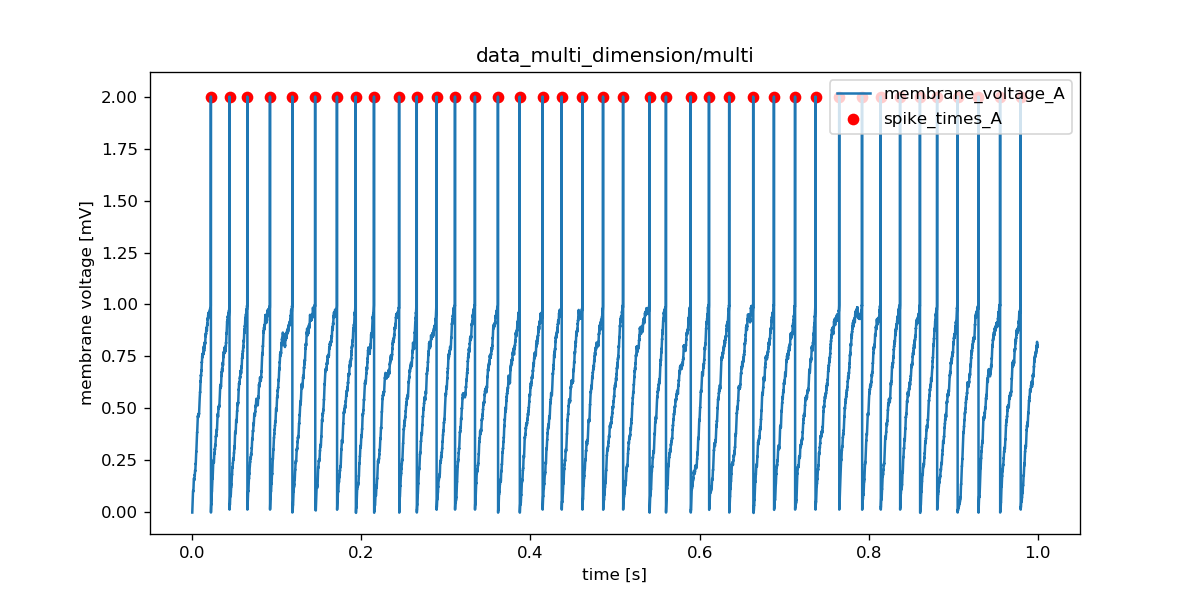

In [278]:
# Now we prepare both initial and analysed data for plotting
dim_sampled = init_data.dimensions[0] # We again reconstruct the time axis
time_points = dim_sampled.axis(init_data.shape[0])

plot.figure(figsize=(10,5))
plot.plot(time_points, init_data[:], label=init_data.name)
plot.scatter(spike_times[:], np.ones(spike_times[:].shape)*np.max(init_data), color='red', label=spike_times.name)

plot.xlabel("%s [%s]" % (dim_sampled.label, dim_sampled.unit))
plot.ylabel("%s [%s]" % (init_data.label, init_data.unit))
plot.title("%s/%s" % (plot_data.name, plot_data.type))
plot.legend()


We can extract information from multiple steps of analysis and are able to plot data and analyses data without having to know or directly access the DataArrays that contain the acutal data.

# Data and data annotation in the same file

NIX does not only allow to save initial data and analysed data within in the same file. It also allows to create structured annotations of the experiments that were conducted and connects this information directly to the data.

Metadata in NIX files is stored in the odML format and is saved in parallel to the actual "DataTree" in a "MetadataTree" but can easily be connected to Data in the DataTree.

odML is a hierarchically structured data format, that provides grouping in nestable 'Sections' and stores information in 'Property'-'Value' pairs.

In [285]:
# Let us annotate the DataArray in our last example.

# As we can see, we have not stored any metadata in our current file yet.
f.sections

[]

In [294]:
# Lets check how we can create a new section:
help(f.create_section)

Help on method create_section in module nixio.file:

create_section(name, type_='undefined', oid=None) method of nixio.file.File instance
    Create a new metadata section inside the file.
    
    :param name: The name of the section to create.
    :type name: str
    :param type_: The type of the section.
    :type type_: str
    :param oid: object id, UUID string as specified in RFC 4122. If no id
                is provided, an id will be generated and assigned.
    :type oid: str
    
    :returns: The newly created section.
    :rtype: Section



In [288]:
# First we need to create a Section that can contain our annotations
section = f.create_section(name="tag_examples", type_="general_section")

f.sections

DuplicateName: Duplicate name - names have to be unique for a given entity type & parent. (create_section)

In [290]:
# This section can contain further sections as well as properties:
section.sections

[]

In [292]:
section.props

[]

In [293]:
# Lets store additional information about the initial data in our tag example.
sub_sec = section.create_section(name="subject", type_="experiment_A")


In [295]:
# Lets add some properties to this section
help(sub_sec.create_property)

Help on method create_property in module nixio.section:

create_property(name, values_or_dtype, oid=None) method of nixio.section.Section instance
    Add a new property to the section.
    
    :param name: The name of the property to create.
    :type name: str
    :param values_or_dtype: The values of the property or a valid DataType.
    :type values_or_dtype: list of values or a DataType
    :param oid: object id, UUID string as specified in RFC 4122. If no id
                is provided, an id will be generated and assigned.
    :type oid: str
    
    :returns: The newly created property.
    :rtype: Property



In [297]:
prop = sub_sec.create_property(name="species", values_or_dtype="Mus Musculus")
prop = sub_sec.create_property(name="age", values_or_dtype="4")
prop.unit = "weeks"
prop = sub_sec.create_property(name="subjectID", values_or_dtype="78376446-f096-47b9-8bfe-ce1eb43a48dc")

DuplicateName: Duplicate name - names have to be unique for a given entity type & parent. (create_property)

In [298]:
# Lets check what we have so far:
f.sections

[Section: {name = tag_examples, type = general_section, id = 80c64e06-80dc-48b5-a0e0-ff49b68657cc}]

In [299]:
# One section that will describe our tag_examples
f.sections['tag_examples'].sections

[Section: {name = subject, type = experiment_A, id = 0cb57aaa-f904-4d42-ac7f-1e50eb92bd1b}]

In [300]:
# A subsection that contains subject related information
f.sections['tag_examples'].sections['subject'].props

[Property: {name = species}, Property: {name = age}]

In [305]:
# We can now connect the section describing our tag_example directly to the MultiTag that references both 
# the initial as well as the analysed data.

multi_tag = f.blocks['tag_examples'].multi_tags['tag_A']
multi_tag.metadata = f.sections['tag_examples']

In [308]:
# Now when we look at the data via a MultiTag we can directly access all metadata that has been attached to it.
# E.g. get information about the subject the experiment was conducted with
multi_tag.metadata.sections['subject']

Section: {name = subject, type = experiment_A, id = 0cb57aaa-f904-4d42-ac7f-1e50eb92bd1b}

In [311]:
# We can also attach the same section to the initial DataArray
init_data = f.blocks['tag_examples'].data_arrays['membrane_voltage_A']
init_data.metadata = f.sections['tag_examples']

In [314]:
# And we can also find it in reverse: we can select a section and find all data, that is connected to it
sec = f.sections['tag_examples']
sec.referring_data_arrays

[DataArray: {name = membrane_voltage_A, type = regular_sampled, id = f179642a-c301-4675-9bbf-7dbfdc0c2751}]

In [315]:
sec.referring_multi_tags

[MultiTag: {name = tag_A, type = spike_times, id = 5ecae4a3-47c4-475d-8af7-6c34232dddb4}]

In [233]:
# And finally we close our file.
f.close()